# DTSA-5511 Week3 - CNN Cancer Detection Kaggle Mini Project

A Jupyter notebook with a description of the problem/data, exploratory data analysis (EDA) procedure, analysis (model building and training), result, and discussion/conclusion.

## Problem
With the help of Machine Learning, use the Convolution Neural Network (CNN) algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans.

### Data
The data comes from Kaggle (https://www.kaggle.com/competitions/histopathologic-cancer-detection/data)

There are three files provided. The first one is train_labels.csv which provides the ground truth for the images in the train folder. The second and third ones are zip file which contains images of 96x96 pixels in Tagged Image File Format (TIFF). 
The test folder contains 57,458 imags and the train folder contains 220,025 images. The labels contains binary values where 0 is non-cancerous and 1 is cancerous.

### Load libraries

In [1]:
# Basic libraries
import pandas as pd
import numpy as np
import os

# Plots
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Data processing, metrics and modeling
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import PReLU
from keras.initializers import Constant

# Supress warning
import warnings
warnings.filterwarnings('ignore')

## 1. Exploratory Data Analysis (EDA)

### 1.1. Data import and basic inspection
Importing the data from the train_labels CSV file and inspecting its content.

In [2]:
# Read the training label data
train_labels = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv', dtype=str)
display(train_labels.info(),train_labels.head(),train_labels.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  object
dtypes: object(2)
memory usage: 3.4+ MB


None

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


,id,label
count,220025,220025
unique,220025,2
top,f38a6374c348f90b587e046aac6079959adf3835,0
freq,1,130908


In [3]:
train_dir = '../input/histopathologic-cancer-detection/train/'
test_dir = '../input/histopathologic-cancer-detection/test/'

print(f"There is {len(os.listdir(test_dir))} training samples")
print(f"There is {len(os.listdir(train_dir))} testing samples")

There is 57458 training samples
There is 220025 testing samples


Determining the category distribution on the training data

In [4]:
# Create a copy of train_labels datagrame
train = train_labels.copy()

# Count per label
train_count = train['label'].value_counts()
train_count

0    130908
1     89117
Name: label, dtype: int64

Plot the distribution of categories to know if the data is balanced or not.

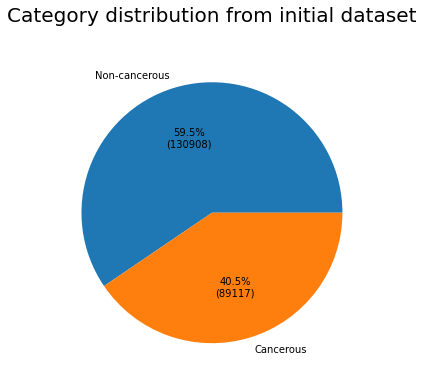

In [5]:
# Helper function from https://stackoverflow.com/questions/59644751/matplotlib-pie-chart-show-both-value-and-percentage
def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{:.1f}%\n({v:d})'.format(pct, v=val)
    return my_format
    
categories = ['Non-cancerous','Cancerous']
values = np.array(train_count.values.tolist())

y = np.array(values)

plt.figure(figsize=(6, 6))
plt.pie(y, labels = categories, autopct=autopct_format(y))
plt.title('Category distribution from initial dataset\n', fontsize="20")
plt.show() 

### 1.2 Data preparation
From the previous step, we found out that the train dataset is imbalance becasue there are more images classified as Non-cancerous tissue than Cancerous tissue. To make the prediction more accurate, I will use Down/Under Sample Majority technique which is the process of randomly selecting samples of majority class and removing them in order to prevent them from dominating over the minority class in the dataset. 

In [6]:
# Dividing majority and minority classes
train_major = train[train.label=='0']
train_minor = train[train.label=='1']

# Down sampling majority class
train_major_sample = resample(train_major,
               replace=False,  # Down sample without replacement
               n_samples=train_minor.shape[0],   # Number to match minority class
               random_state=42)

# Combine down sampled majority class and minority class
train_balanced = pd.concat([train_major_sample, train_minor]).reset_index(drop=True)
   
# Display count of data points in both class
print(train_balanced.label.value_counts())

0    89117
1    89117
Name: label, dtype: int64


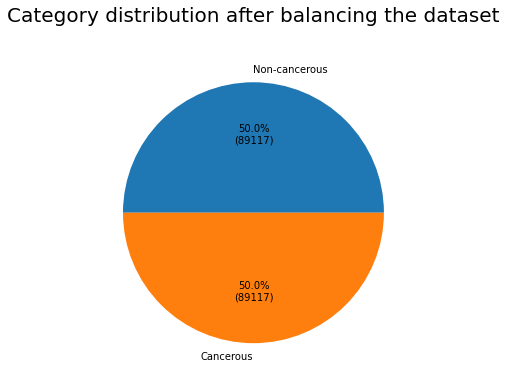

In [7]:
# Count per label
train_count_aft = train_balanced['label'].value_counts()
train_count_aft

categories = ['Non-cancerous','Cancerous']
values = np.array(train_count_aft.values.tolist())

y = np.array(values)
plt.figure(figsize=(6, 6))
plt.pie(y, labels = categories, autopct=autopct_format(y))
plt.title('Category distribution after balancing the dataset\n', fontsize="20")
plt.show() 

After the technique has been applied, we can see that the data is balance now.
### 1.3 Printing images

'Non-cancerous'

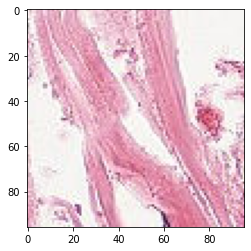

In [8]:
# Getting the first image on the balanced set
path = "{0}{1}.tif".format(train_dir, train_balanced.iloc[0,0] )
img = mpimg.imread(path)
imgplot = plt.imshow(img)
label = train_balanced.iloc[0,1]
'Non-cancerous' if label == '0' else 'Cancerous'

In [9]:
# Get image size
print(img.shape)

(96, 96, 3)


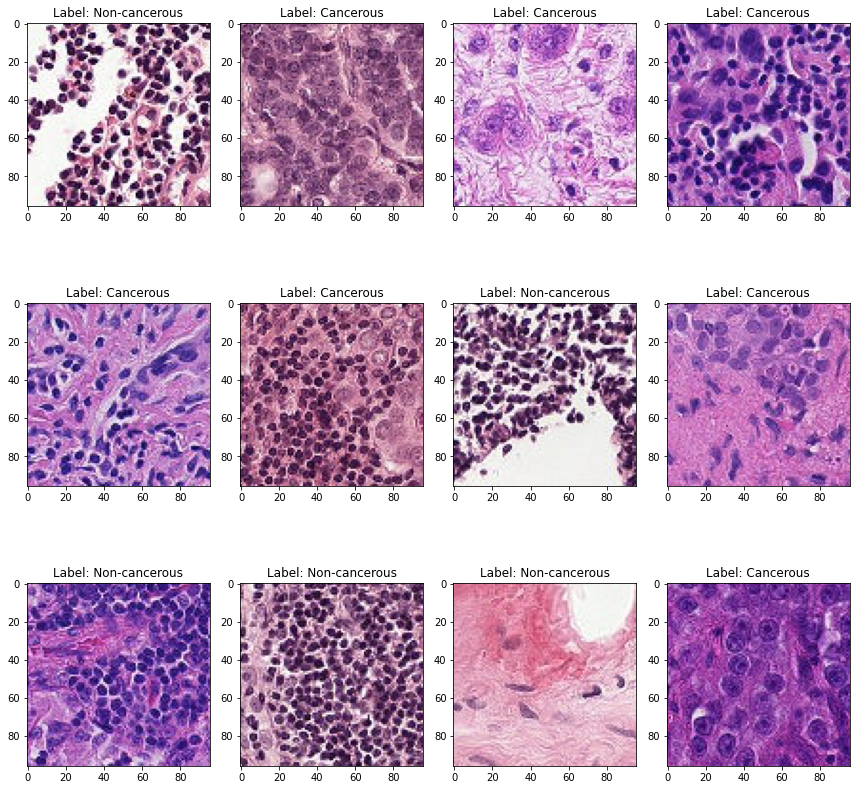

In [10]:
# Randomly select 12 images
sample_imgs = np.random.choice(train_balanced.index,12)

fig, ax = plt.subplots(3, 4,figsize=(12,12))

for i in range(0, sample_imgs.shape[0]):
    ax = plt.subplot(3, 4, i+1)
    img = mpimg.imread(f'../input/histopathologic-cancer-detection/train/{train_balanced.iloc[sample_imgs[i],0]}.tif')
    ax.imshow(img)
    lab = train_balanced.iloc[sample_imgs[i],1]
    labname = 'Non-cancerous' if lab == '0' else 'Cancerous'
    ax.set_title('Label: %s'%labname)
    
plt.tight_layout()

The images are different from each other and it is difficult to know which images are non-cancerous and cancerous without the labels.
## 2. Model building, training and prediction

In [11]:
# Splitting the training set
train_df, valid_df = train_test_split(train_balanced, test_size=0.25, random_state=1234, 
                                      stratify=train_balanced.label)
# Adding the extension file of the images
train_df['id'] = train_df['id']+'.tif'
valid_df['id'] = valid_df['id']+'.tif'
# Converting data type of label
train_df['label'] = train_df['label'].astype(str)
valid_df['label'] = valid_df['label'].astype(str)

In [12]:
#create the training and validation subsets
train_datagen=ImageDataGenerator(rescale=1/255)

train_generator=train_datagen.flow_from_dataframe(dataframe=train_df,directory=train_dir,
                x_col="id",y_col="label",batch_size=64,seed=1234,shuffle=True,
                class_mode="binary",target_size=(96,96))

valid_generator=train_datagen.flow_from_dataframe(dataframe=valid_df,directory=train_dir,
                x_col="id",y_col="label",batch_size=64,seed=1234,shuffle=True,
                class_mode="binary",target_size=(96,96))

Found 133675 validated image filenames belonging to 2 classes.
Found 44559 validated image filenames belonging to 2 classes.


Create a basic CNN model

In [13]:
#model  with 4 convolutional layers
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(img.shape[0], img.shape[1], img.shape[2])))
model.add(layers.MaxPooling2D((2, 2)))
model.add(BatchNormalization())

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(BatchNormalization())

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(BatchNormalization())

model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(512, activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(1, activation = "sigmoid"))

opt = tf.keras.optimizers.Adam(0.001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 46, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 23, 23, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 128)       7

2022-09-18 17:37:07.194932: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


### 2.2 Training

In [14]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

modelfit = model.fit_generator(generator=train_generator,
                              validation_data=valid_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,                    
                              validation_steps=STEP_SIZE_VALID,
                              epochs=10, verbose=1
)

Epoch 1/10


2022-09-18 17:37:07.494501: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


2088/2088 [==============================] - 1258s 602ms/step - loss: 0.4250 - accuracy: 0.8313 - val_loss: 0.6322 - val_accuracy: 0.7308
Epoch 2/10
2088/2088 [==============================] - 1092s 523ms/step - loss: 0.2773 - accuracy: 0.8878 - val_loss: 0.3560 - val_accuracy: 0.8640
Epoch 3/10
2088/2088 [==============================] - 1097s 526ms/step - loss: 0.2182 - accuracy: 0.9156 - val_loss: 0.7716 - val_accuracy: 0.7229
Epoch 4/10
2088/2088 [==============================] - 1093s 524ms/step - loss: 0.1853 - accuracy: 0.9298 - val_loss: 0.4572 - val_accuracy: 0.8398
Epoch 5/10
2088/2088 [==============================] - 1093s 523ms/step - loss: 0.1600 - accuracy: 0.9395 - val_loss: 0.2066 - val_accuracy: 0.9198
Epoch 6/10
2088/2088 [==============================] - 1084s 519ms/step - loss: 0.1361 - accuracy: 0.9486 - val_loss: 0.3118 - val_accuracy: 0.8916
Epoch 7/10
2088/2088 [==============================] - 1110s 531ms/step - loss: 0.1149 - accuracy: 0.9564 - val_loss

### 2.3 Evaluation

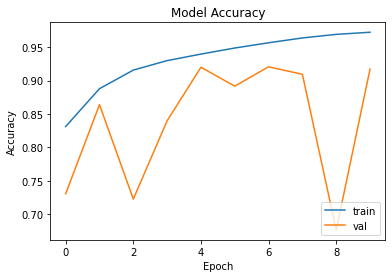

In [15]:
plt.plot(modelfit.history['accuracy'], label='train')
plt.plot(modelfit.history['val_accuracy'], label = 'val')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

After plotting the accurcay results from the basic CNN model, it can be observed that the accuracy reaches about 97% accuracy after 10 epochs. 

### 2.4 PReLU
The basic CNN model got a very good accuracy but for the tuning purposes I will add PReLU (Parametric Rectified Linear Unit) to see if I am able to improve more the model. PReLU is an activation function that adaptively learns the parameters of the rectifiers, and improves accuracy at negligible extra computational cost.I will also change the optimizer using RMSprop which is a gradien-based optimization technique. It uses an adaptive learning rate instead of treating the learning rate as a hyperparameter. This means that the learning rate changes over time.

In [16]:
#model  with 4 convolutional layers
model1 = models.Sequential()
model1.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(img.shape[0], img.shape[1], img.shape[2])))
model1.add(PReLU(alpha_initializer=Constant(value=0.25)))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(BatchNormalization())

model1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model1.add(PReLU(alpha_initializer=Constant(value=0.25)))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(BatchNormalization())

model1.add(layers.Conv2D(128, (3, 3), activation='relu'))
model1.add(PReLU(alpha_initializer=Constant(value=0.25)))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(BatchNormalization())

model1.add(Flatten())
model1.add(Dropout(0.2))
model1.add(Dense(512, activation = "relu"))
model1.add(Dropout(0.2))
model1.add(Dense(1, activation = "sigmoid"))

opt = tf.keras.optimizers.RMSprop(0.001)
model1.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 96, 96, 32)        896       
_________________________________________________________________
p_re_lu (PReLU)              (None, 96, 96, 32)        294912    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 46, 46, 64)        18496     
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 46, 46, 64)        135424    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 23, 23, 64)       

In [17]:
modeltune = model1.fit_generator(generator=train_generator,
                              validation_data=valid_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,                    
                              validation_steps=STEP_SIZE_VALID,
                              epochs=10, verbose=1
)

Epoch 1/10
2088/2088 [==============================] - 1220s 583ms/step - loss: 0.5109 - accuracy: 0.8299 - val_loss: 15.7239 - val_accuracy: 0.6228
Epoch 2/10
2088/2088 [==============================] - 1226s 587ms/step - loss: 0.3034 - accuracy: 0.8799 - val_loss: 0.4782 - val_accuracy: 0.7972
Epoch 3/10
2088/2088 [==============================] - 1229s 589ms/step - loss: 0.2694 - accuracy: 0.8966 - val_loss: 0.4965 - val_accuracy: 0.8306
Epoch 4/10
2088/2088 [==============================] - 1226s 587ms/step - loss: 0.2488 - accuracy: 0.9049 - val_loss: 17.5053 - val_accuracy: 0.6902
Epoch 5/10
2088/2088 [==============================] - 1228s 588ms/step - loss: 0.2401 - accuracy: 0.9108 - val_loss: 10.8265 - val_accuracy: 0.6735
Epoch 6/10
2088/2088 [==============================] - 1227s 588ms/step - loss: 0.2288 - accuracy: 0.9162 - val_loss: 0.7025 - val_accuracy: 0.8670
Epoch 7/10
2088/2088 [==============================] - 1227s 587ms/step - loss: 0.2210 - accuracy: 0.9

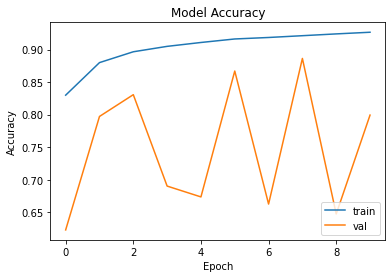

In [18]:
plt.plot(modeltune.history['accuracy'], label='train')
plt.plot(modeltune.history['val_accuracy'], label = 'val')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

### 2.5 Prediction
As using the PReLU and RMSprop optimizer didn't improve the accuracy, I will use the first model created for the prediction. It seems that Adam optimizer works better than the RMSprop and the PReLU activation layer is not needed for improving the accuracy.

In [19]:
# create the test dataframe
test_set = os.listdir(test_dir)
test_df = pd.DataFrame(test_set)
test_df.columns = ['id']

# create the test subset
test_datagen=ImageDataGenerator(rescale=1/255)

test_generator=test_datagen.flow_from_dataframe(dataframe=test_df,directory=test_dir,
                x_col="id",batch_size=64,seed=1234,shuffle=False,
                class_mode=None,target_size=(96,96))

Found 57458 validated image filenames.


In [20]:
test_df.shape

(57458, 1)

In [21]:
# generate the prediction
STEP_SIZE_TEST=test_generator.n/2
preds = model1.predict_generator(generator=test_generator, steps=STEP_SIZE_TEST, verbose = 1)

28729/28729 [==============================] - 509s 18ms/step


In [22]:
# generate the labels with value 1 and 0
predictions = []

for pred in preds:
    if pred >= 0.5:
        predictions.append(1)
    else:
        predictions.append(0)
        
predictions[:10]

[1, 0, 0, 1, 0, 1, 1, 1, 1, 1]

In [23]:
# generate the submission file
submission = test_df.copy()
submission['id']=submission['id'].str[:-4]
submission['label']=predictions
submission.head()
submission.to_csv('submission.csv',index=False)

## 3. Discussion
### 3.1 Conclusion

The initial architecture of the model uses a common pattern for the convolutional base which is a stack of Conv2D and MaxPooling2D with a Batch normalization method to make the training faster and more stable. Dropout is applied to cut too much association among features. Dense and flatten layers are added for model improvement. The accuracy of this model reached 97% at 10 epoch. Although the accuracy was pretty good, I wanted to test if adding the PReLU activate function and RMSprop optimizer will reach higher accuracy. However, the highest accuracy reached was 92% at 10 epochs. Thus, I used the first model to predict the test data. 

### 3.2 Future improvement
For this assignment, up to 10 epoch times were used because it takes long time to run. If the epoch times are increased, the training dataseet will have an opportunity to update the internal model parameters. Therefore, a future improvements wiill be adding more layers and more number of epochs to improve the accuracy of the model.